In [1]:
import starepandas
import geopandas
import pandas
import datetime
import matplotlib.pyplot as plt

In [2]:
cities = ['Buenos Aires', 'Brasilia', 'Santiago', 
          'Bogota', 'Caracas', 'Sao Paulo', 'Bridgetown']

latitudes = [-34.58, -15.78, -33.45, 4.60, 10.48, -23.55, 13.1]
longitudes = [-58.66, -47.91, -70.66, -74.08, -66.86, -46.63, -59.62]
data =  {'City': cities, 
         'Latitude': latitudes, 'Longitude': longitudes}

cities = starepandas.STAREDataFrame(data)
stare = starepandas.stare_from_xy(cities.Longitude, cities.Latitude, level=26)
geom = geopandas.points_from_xy(cities.Longitude, cities.Latitude, crs='EPSG:4326')
cities.set_stare(stare, inplace=True)
cities.set_geometry(geom, inplace=True)
cities.set_trixels(inplace=True)

In [3]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
samerica = countries[countries.continent=='South America']

stare = starepandas.stare_from_gdf(samerica, level=7, force_ccw=True)
samerica = starepandas.STAREDataFrame(samerica, stare=stare)
trixels = samerica.make_trixels()
samerica.set_trixels(trixels, inplace=True)

# Small Join

In [4]:
geopandas.sjoin(samerica, cities, how='left').head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,stare_left,trixels_left,index_right,City,Latitude,Longitude,stare_right,trixels_right
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...","[1831874332805038087, 1831909517177126919, 183...",(POLYGON ((-68.10743917965794 -55.318013510029...,0.0,Buenos Aires,-34.58,-58.66,2.663379e+18,POLYGON ((-58.66000098601791 -34.5799992503424...
10,17789267,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...","[1822268999224786951, 1822339367968964615, 182...",(POLYGON ((-70.49911208115833 -54.876220492643...,2.0,Santiago,-33.45,-70.66,2.723775e+18,POLYGON ((-70.65999968646292 -33.4500013463725...
20,2931,South America,Falkland Is.,FLK,281.8,"POLYGON ((-61.20000 -51.85000, -60.00000 -51.2...","[1807104534854500359, 1807245272342855687, 180...",(POLYGON ((-60.67409060746598 -51.685030822190...,NaN,NaN,NaN,NaN,NaN,NaN
28,3360148,South America,Uruguay,URY,73250.0,"POLYGON ((-57.62513 -30.21629, -56.97603 -30.1...","[2632353982198054918, 2661627379775963142, 266...",(POLYGON ((-55.17661686795088 -32.247895158077...,NaN,NaN,NaN,NaN,NaN,NaN
29,207353391,South America,Brazil,BRA,3081000.0,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...","[2749447572509687812, 2796735368597078020, 286...",(POLYGON ((-53.69933849725345 -4.6308011280983...,1.0,Brasilia,-15.78,-47.91,2.867415e+18,POLYGON ((-47.91000053679528 -15.7800012927208...


# Granule Intersect

In [5]:
fname = '../tests/data/granules/MYD05_L2.A2020060.1635.061.2020061153519.hdf'

In [6]:
# Reading and bootstraping
start = datetime.datetime.now()
modis = starepandas.read_granule(fname,
                                 add_stare=True,
                                 adapt_resolution=True,
                                 track_first=False)
print(datetime.datetime.now() - start)

0:00:01.271735


In [8]:
# Adding Trixels
trixels = modis.make_trixels()
modis.set_trixels(trixels, inplace=True)

In [9]:
# Adding Simple Feauture Representations
geom = geopandas.points_from_xy(modis.lon, modis.lat, crs='EPSG:4326')
modis.set_geometry(geom, inplace=True)

In [10]:
brazil = samerica[samerica.name=='Brazil']

## STARE based intersects test

In [11]:
start = datetime.datetime.now()
b = modis.intersects(brazil.iloc[0].geometry)
print(datetime.datetime.now() - start)

0:00:03.374820


## GEOS based intersects test

In [12]:
start = datetime.datetime.now()
a = modis.stare_intersects(brazil['stare'].iloc[0])
print(datetime.datetime.now() - start)

0:00:00.176304


# Analysis

<AxesSubplot:>

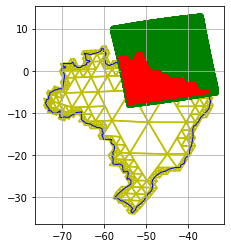

In [13]:
fig, ax = plt.subplots()
ax.grid(True)

brazil.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=0)
brazil.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)
modis[a].plot(ax=ax, color='red', trixels=True)
modis.plot(ax=ax, color='green')

In [16]:
joined = starepandas.stare_join(modis, samerica, how='left')
joined = geopandas.GeoDataFrame(joined).set_geometry('geometry')

<AxesSubplot:>

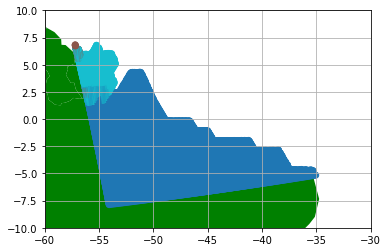

In [17]:
fig, ax = plt.subplots()
ax.grid(True)

ax.set_ylim(-10, 10)
ax.set_xlim(-60, -30)
samerica.plot(ax=ax, color='green')
joined.plot(ax=ax, column='name')